In [ ]:
# Given a fixed number of assets available for response, how often do we approach 10%, 25% and 50% of resources being used.
# When was the highest percent of resources used and for how long?
# What happens to overall response times when these occur?
# What stations are consistently at the highest % time of resources being used?
# Is it because they are handling their own calls or another area’s?

In [1]:
import pandas as pd
from pprint import pprint
import boto3
import os
from io import StringIO
import matplotlib.pyplot as plt
import numpy as np
import statistics
%matplotlib inline

In [5]:
client = boto3.client('s3')
bucket_name = 'rescue-me-team-bucket'
object_key = 'data/GMU_2021_Summer_Capacity.csv'
csv_obj = client.get_object(Bucket=bucket_name, Key=object_key)
body = csv_obj['Body']
csv_string = body.read().decode('utf-8')

capacity_df = pd.read_csv(StringIO(csv_string))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# mark unit types
def mark_unit_type(x):
    if x[0]=='A':
        return 'ambulance'
    elif x[0]=='E':
        return 'engine'
    elif x[0]=='M':
        return 'medic'
    elif x[0]=='R':
        return 'rescue squad'
    elif x[:2] in ['TT','TL'] or x[0] == 'T':
        return 'truck/tiller/tower'
    
    # nothing picked up return none
    return 'unknown'

def fix_inc_bn(x):
    if x != 'nan':
        try:
            return str(int(float(x)))
        except:
            print(x,type(x))
    return 'unknown'

lookup_table={
'AK':'acknowledge',
'AM':'available on mobile (cell phone)',
'AQ':'available in quarters (station)',
'AR':'available on radio',
'DP':'dispatched',
'ER':'enroute',
'OS':'on-scene',
'OT':'out of service',
'TA':'transport arrived (at medical facility)',
'TR':'transport (begins)',
'WP':'with patient'
}
pprint(lookup_table)

{'AK': 'acknowledge',
 'AM': 'available on mobile (cell phone)',
 'AQ': 'available in quarters (station)',
 'AR': 'available on radio',
 'DP': 'dispatched',
 'ER': 'enroute',
 'OS': 'on-scene',
 'OT': 'out of service',
 'TA': 'transport arrived (at medical facility)',
 'TR': 'transport (begins)',
 'WP': 'with patient'}


In [7]:
capacity_df['status_desc']=capacity_df['CAD_UnitStatus'].map(lookup_table)
capacity_df['day']=capacity_df['CAD_Timestamp'].str[:8]

# cleanup string issues
capacity_df['UnitBattalion']=capacity_df['UnitBattalion'].astype(str)
capacity_df['IncidentBattalion']=capacity_df['IncidentBattalion'].astype(str)
#capacity_df['IncidentBattalion']=capacity_df['IncidentBattalion'].fillna(0)
capacity_df['UnitStation']=capacity_df['UnitStation'].astype(str)
capacity_df['unit_type'] = capacity_df.apply(lambda x: mark_unit_type(x['CAD_UnitID']), axis=1)

# int and flaot cleanup (to str)
# capacity_df['IncidentBattalion']=capacity_df['IncidentBattalion'].round()
# capacity_df['UnitBattalion'] = capacity_df['UnitBattalion'].astype(str)
# capacity_df['IncidentBattalion'] = capacity_df['IncidentBattalion'].astype(str)
capacity_df['IncidentBattalion'] = capacity_df.apply(lambda x: fix_inc_bn(x['IncidentBattalion']), axis=1)

capacity_df

# check for duplicates
# capacity_df[capacity_df.duplicated(keep=False)]

,IncidentNumber,CallConfirmedDT,IncidentCategory,IncidentBattalion,IncidentFirstDue,CAD_UnitID,UnitBattalion,UnitStation,CAD_Timestamp,CAD_UnitStatus,Shift,status_desc,day,unit_type
0,E170010002,2017-01-01 00:01:10,E,unknown,NaN,E410,408,10,20170101000307ES,ER,C,enroute,20170101,engine
1,E170010002,2017-01-01 00:01:10,E,unknown,NaN,E410,408,10,20170101000926ES,WP,C,with patient,20170101,engine
2,E170010002,2017-01-01 00:01:10,E,unknown,NaN,M410B,408,10,20170101012905ES,CU,C,NaN,20170101,medic
3,E170010008,2017-01-01 00:01:01,F,401,439.0,E439,401,39,20170101000302ES,DP,C,dispatched,20170101,engine
4,E170010008,2017-01-01 00:01:01,F,401,439.0,TT425,401,25,20170101000520ES,ER,C,enroute,20170101,truck/tiller/tower
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4420055,E203662405,2020-12-31 23:47:48,E,408,422.0,M422,408,22,20210101001603ES,TA,A,transport arrived (at medical facility),20210101,medic
4420056,E203662422,2020-12-31 23:56:27,E,402,444.0,E413,402,13,20210101000330ES,OS,A,on-scene,20210101,engine
4420057,E203662422,2020-12-31 23:56:27,E,402,444.0,M413,402,13,20201231235831ES,DP,A,dispatched,20201231,medic
4420058,E203662422,2020-12-31 23:56:27,E,402,444.0,M413,402,13,20210101000427ES,WP,A,with patient,20210101,medic


In [8]:
capacity_df.dtypes

IncidentNumber        object
CallConfirmedDT       object
IncidentCategory      object
IncidentBattalion     object
IncidentFirstDue     float64
CAD_UnitID            object
UnitBattalion         object
UnitStation           object
CAD_Timestamp         object
CAD_UnitStatus        object
Shift                 object
status_desc           object
day                   object
unit_type             object
dtype: object

In [9]:
capacity_df.isna().sum()

IncidentNumber            0
CallConfirmedDT           0
IncidentCategory          0
IncidentBattalion         0
IncidentFirstDue     126236
CAD_UnitID                0
UnitBattalion             0
UnitStation               0
CAD_Timestamp             0
CAD_UnitStatus            0
Shift                     0
status_desc          344967
day                       0
unit_type                 0
dtype: int64

In [10]:
capacity_df[capacity_df['status_desc'].isna()]['CAD_UnitStatus'].unique()

array(['CU', '~', 'UE', 'UU', 'UC', 'CL', 'UT', 'SC', 'SX', 'XB', 'XC',
       'XE', 'DW', 'UG', 'AV', '1R', 'UV', 'RB', 'TU', 'AF'], dtype=object)

In [ ]:
capacity_df[capacity_df['CAD_UnitStatus']=='~']

In [ ]:
# 4 year timespan
print('min time:',capacity_df['CAD_Timestamp'].min())
print('max time:',capacity_df['CAD_Timestamp'].max())

In [ ]:
capacity_df['IncidentNumber'].nunique() # ~100 k unique incidents

In [ ]:
print('# unique Battalions:',capacity_df['UnitBattalion'].nunique()) # 17 unique Battalions
capacity_df['UnitBattalion'].unique()

In [ ]:
capacity_df['IncidentBattalion'].unique()

In [ ]:
print('# unique first due:',capacity_df['IncidentFirstDue'].nunique())
capacity_df['IncidentFirstDue'].unique()

In [ ]:
print('# unique unit station:',capacity_df['UnitStation'].nunique()) # 77 unique stations
capacity_df['UnitStation'].unique()

In [ ]:
print('# unique CAD unitID:',capacity_df['CAD_UnitID'].nunique()) # 171 unique units
capacity_df['CAD_UnitID'].unique()

In [ ]:
print(capacity_df['unit_type'].nunique())
capacity_df['unit_type'].unique()

In [19]:
def process_df(df):
    # intialize values for the whole fleet
    current_dict={}
    day_max_dict={}
    return_set=set(['AM','AQ','AR'])
    max_deployment=0
    current_deploy_per=0.0
    prev_deploy_per=0.0
    count_10,count_25,count_50=0,0,0
    unique_unit_count=df['CAD_UnitID'].nunique()

    # deep only dispatch or available events
    temp_df=df[capacity_df['CAD_UnitStatus'].isin(['AM','AQ','AR','DP'])]
    # sort entire df
    temp_df.sort_values(by=['CAD_Timestamp'])

    # loop through every element in df
    for index, row in temp_df.sort_values(by=['CAD_Timestamp'])[:].iterrows():    
        # if dispatched add unit to collection of dispatched units
        if row['CAD_UnitStatus']=='DP':
            # add to master dictionary
            current_dict[row['CAD_UnitID']]=row    
        # if AM, AQ, or AR then release
        elif row['CAD_UnitStatus'] in return_set:
            # remove from master dictionary
            if row['CAD_UnitID'] in current_dict:
                del current_dict[row['CAD_UnitID']]

        # check length of set vs. max
        current_num = len(current_dict)
        
        # get number that are "out of zone"
        out_of_zone_count=0
        for v in current_dict.values():
            if v['IncidentBattalion'] != v['UnitBattalion']:
                out_of_zone_count+=1
        
        if current_num > max_deployment:
            max_deployment=len(current_dict) # record a new max number of unique units deployed
            print('new max deployed #:',len(current_dict),row['CAD_Timestamp'])
            max_dict = current_dict.copy() # copy all the units deployed at the new max

        # populate the dict that will track the max % deployed per day
        current_deploy_per=current_num/unique_unit_count
        
        # get % deployed from out of zone
        if len(current_dict)>0:
            out_of_zone_per=out_of_zone_count/len(current_dict)
        else:
            out_of_zone_per=0.0
        
        if row['day'] not in day_max_dict:
            day_max_dict[row['day']]=(current_deploy_per,out_of_zone_per)
        else:
            if current_deploy_per > day_max_dict[row['day']][0]:
                day_max_dict[row['day']]=(current_deploy_per,out_of_zone_per)

    # print('\n','max len dict:',len(max_dict))
    for i,v in max_dict.items():
        print(i,'|',v['CAD_Timestamp'][0:4],v['CAD_Timestamp'][4:6],v['CAD_Timestamp'][6:8],v['CAD_Timestamp'],v['IncidentBattalion'],v['UnitBattalion'],v['IncidentBattalion']==v['UnitBattalion'])
    
    # return a dictionary with the max % deployed by day, as well as a count of the max # deployed
    return day_max_dict, max_deployment

In [18]:
# essential medics are 8,9,10,11
medics_to_remove=['M422B', 'M427B', 'M402B','M414B', 'M417B', 'M401B'] # should leave 42? we see 50.  Also 48, not 38 engines
# filter to essential units
# capacity_df[(capacity_df['unit_type']=='engine')|(capacity_df['unit_type']=='medic')]['CAD_UnitID'].unique()
#capacity_df[(capacity_df['unit_type']=='medic') & ~(capacity_df['CAD_UnitID'].isin(medics_to_remove))]['CAD_UnitID'].nunique()
# capacity_df[(capacity_df['unit_type']=='engine')]['CAD_UnitID'].unique()
essential_df=capacity_df[(capacity_df['unit_type']=='engine')|((capacity_df['unit_type']=='medic') & ~(capacity_df['CAD_UnitID'].isin(medics_to_remove)))]

In [20]:
%%time
overall_day_max_dict,overall_max_deployment=process_df(capacity_df)
essential_day_max_dict,essential_max_deployment=process_df(essential_df)
ambulance_day_max_dict,ambulance_max_deployment=process_df(capacity_df[capacity_df['unit_type']=='ambulance'])
engine_day_max_dict,engine_max_deployment=process_df(capacity_df[capacity_df['unit_type']=='engine'])
medic_day_max_dict,medic_max_deployment=process_df(capacity_df[capacity_df['unit_type']=='medic'])
rescue_day_max_dict,rescue_max_deployment=process_df(capacity_df[capacity_df['unit_type']=='rescue squad'])
ttt_day_max_dict,ttt_max_deployment=process_df(capacity_df[capacity_df['unit_type']=='truck/tiller/tower'])

new max deployed #: 1 20170101000137ES
new max deployed #: 2 20170101000137ES
new max deployed #: 3 20170101000302ES
new max deployed #: 4 20170101000303ES
new max deployed #: 5 20170101000523ES
new max deployed #: 6 20170101000524ES
new max deployed #: 7 20170101000801ES
new max deployed #: 8 20170101000802ES
new max deployed #: 9 20170101001142ES
new max deployed #: 10 20170101001143ES
new max deployed #: 11 20170101001223ES
new max deployed #: 12 20170101001224ES
new max deployed #: 13 20170101001309ES
new max deployed #: 14 20170101001433ES
new max deployed #: 15 20170101001434ES
new max deployed #: 16 20170101001514ES
new max deployed #: 17 20170101001515ES
new max deployed #: 18 20170101001612ES
new max deployed #: 19 20170101003307ES
new max deployed #: 20 20170101003407ES
new max deployed #: 21 20170101003408ES
new max deployed #: 22 20170101003448ES
new max deployed #: 23 20170101003525ES
new max deployed #: 24 20170101003614ES
new max deployed #: 25 20170101010018ES
new max d

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


new max deployed #: 1 20170101000137ES
new max deployed #: 2 20170101000137ES
new max deployed #: 3 20170101000302ES
new max deployed #: 4 20170101000523ES
new max deployed #: 5 20170101000524ES
new max deployed #: 6 20170101000801ES
new max deployed #: 7 20170101000802ES
new max deployed #: 8 20170101001142ES
new max deployed #: 9 20170101001143ES
new max deployed #: 10 20170101001223ES
new max deployed #: 11 20170101001224ES
new max deployed #: 12 20170101001309ES
new max deployed #: 13 20170101001433ES
new max deployed #: 14 20170101001434ES
new max deployed #: 15 20170101001515ES
new max deployed #: 16 20170101003407ES
new max deployed #: 17 20170101003408ES
new max deployed #: 18 20170101003448ES
new max deployed #: 19 20170101003525ES
new max deployed #: 20 20170101003614ES
new max deployed #: 21 20170101005737ES
new max deployed #: 22 20170101010018ES
new max deployed #: 23 20170101010206ES
new max deployed #: 24 20170101140356ES
new max deployed #: 25 20170102183501ES
new max d

new max deployed #: 1 20170101000137ES
new max deployed #: 2 20170101000524ES
new max deployed #: 3 20170101000801ES
new max deployed #: 4 20170101001142ES
new max deployed #: 5 20170101001224ES
new max deployed #: 6 20170101001309ES
new max deployed #: 7 20170101001434ES
new max deployed #: 8 20170101001515ES
new max deployed #: 9 20170101002223ES
new max deployed #: 10 20170101002311ES
new max deployed #: 11 20170101003614ES
new max deployed #: 12 20170101005444ES
new max deployed #: 13 20170101005622ES
new max deployed #: 14 20170101005654ES
new max deployed #: 15 20170101005737ES
new max deployed #: 16 20170101144958ES
new max deployed #: 17 20170101145809ES
new max deployed #: 18 20170102183501ES
new max deployed #: 19 20170102183545ES
new max deployed #: 20 20170103110047ES
new max deployed #: 21 20170103110648ES
new max deployed #: 22 20170103111349ES
new max deployed #: 23 20170103111519ES
new max deployed #: 24 20170103111612ES
new max deployed #: 25 20170103112310ES
new max d

In [22]:
overall_day_max_dict

{'20170101': (0.1695906432748538, 0.06896551724137931),
 '20170102': (0.18128654970760233, 0.25806451612903225),
 '20170103': (0.24561403508771928, 0.42857142857142855),
 '20170104': (0.16374269005847952, 0.17857142857142858),
 '20170105': (0.17543859649122806, 0.23333333333333334),
 '20170106': (0.22807017543859648, 0.3076923076923077),
 '20170107': (0.14619883040935672, 0.16),
 '20170108': (0.17543859649122806, 0.43333333333333335),
 '20170109': (0.23391812865497075, 0.275),
 '20170110': (0.19298245614035087, 0.09090909090909091),
 '20170111': (0.19883040935672514, 0.17647058823529413),
 '20170112': (0.21637426900584794, 0.21621621621621623),
 '20170113': (0.19883040935672514, 0.38235294117647056),
 '20170114': (0.1871345029239766, 0.125),
 '20170115': (0.18128654970760233, 0.12903225806451613),
 '20170116': (0.2631578947368421, 0.28888888888888886),
 '20170117': (0.2222222222222222, 0.10526315789473684),
 '20170118': (0.1695906432748538, 0.13793103448275862),
 '20170119': (0.1578947

In [23]:
# clean up all dictionaries
# loop through all possible days
def fill_in_blanks(in_dict,day_list):
    temp_dict=in_dict.copy()
    counter=0
    for i in day_list:
        counter+=1
        day=str(i)
        if day not in temp_dict:
            temp_dict[day]=(0.0,0.0)
    #print('counter:',counter)
    return temp_dict
day_list=overall_day_max_dict.keys()
ambulance_day_max_dict=fill_in_blanks(ambulance_day_max_dict,day_list)
rescue_day_max_dict=fill_in_blanks(rescue_day_max_dict,day_list)
ttt_day_max_dict=fill_in_blanks(ttt_day_max_dict,day_list)
essential_day_max_dict=fill_in_blanks(essential_day_max_dict,day_list)
#pprint(ttt_day_max_dict)
# should have 1462 days total
# show all lens
print('overall:',len(overall_day_max_dict))
print('ambulance:',len(ambulance_day_max_dict))
print('engine:',len(engine_day_max_dict))
print('medic:',len(medic_day_max_dict))
print('rescue:',len(rescue_day_max_dict))
print('ttt:',len(ttt_day_max_dict))
print('essential:',len(essential_day_max_dict))

overall: 1462
ambulance: 1462
engine: 1462
medic: 1462
rescue: 1462
ttt: 1462
essential: 1462


In [26]:
ambulance_day_max_dict

{'20170101': (0.03571428571428571, 0.0),
 '20170102': (0.07142857142857142, 0.5),
 '20170103': (0.03571428571428571, 0.0),
 '20170104': (0.03571428571428571, 1.0),
 '20170105': (0.03571428571428571, 0.0),
 '20170106': (0.03571428571428571, 0.0),
 '20170107': (0.03571428571428571, 0.0),
 '20170109': (0.03571428571428571, 0.0),
 '20170110': (0.07142857142857142, 0.0),
 '20170111': (0.03571428571428571, 0.0),
 '20170112': (0.03571428571428571, 0.0),
 '20170113': (0.03571428571428571, 0.0),
 '20170114': (0.10714285714285714, 0.0),
 '20170116': (0.07142857142857142, 0.5),
 '20170117': (0.07142857142857142, 0.5),
 '20170118': (0.07142857142857142, 0.0),
 '20170119': (0.07142857142857142, 0.0),
 '20170120': (0.17857142857142858, 0.0),
 '20170121': (0.07142857142857142, 0.5),
 '20170122': (0.03571428571428571, 0.0),
 '20170123': (0.03571428571428571, 1.0),
 '20170124': (0.03571428571428571, 0.0),
 '20170125': (0.03571428571428571, 0.0),
 '20170127': (0.03571428571428571, 1.0),
 '20170128': (0.

In [33]:
def basic_stats(dict):
    deploy_sum=sum([pair[0] for pair in dict.values()])
    print('mean max deploy:',round(deploy_sum/len(dict.values()),3))
    deploy_stdev=statistics.stdev([pair[0] for pair in dict.values()])
    print('stdev max deploy:',round(deploy_stdev,3))
    
    out_deploy_sum=sum([pair[1] for pair in dict.values()])
    print('mean out of sector during max deploy:',round(out_deploy_sum/len(dict.values()),3))
    out_deploy_stdev=statistics.stdev([pair[1] for pair in dict.values()])
    print('stdev of out of sector during max deploy:',round(out_deploy_stdev,3))
    
    #print('mean max deploy:',round(sum(dict.values())/len(dict.values()),3))
    #print('stdev max deploy:',round(statistics.stdev(dict.values()),3))

print('# overall:')
basic_stats(overall_day_max_dict)

print('# ambulance:')
basic_stats(ambulance_day_max_dict)

print('# engine:')
basic_stats(engine_day_max_dict)

print('# medic:')
basic_stats(medic_day_max_dict)

print('# rescue:')
basic_stats(rescue_day_max_dict)

print('# ttt:')
basic_stats(ttt_day_max_dict)

print('# essential:')
basic_stats(essential_day_max_dict)

# overall:
mean max deploy: 0.197
stdev max deploy: 0.032
mean out of sector during max deploy: 0.252
stdev of out of sector during max deploy: 0.102
# ambulance:
mean max deploy: 0.054
stdev max deploy: 0.032
mean out of sector during max deploy: 0.268
stdev of out of sector during max deploy: 0.38
# engine:
mean max deploy: 0.237
stdev max deploy: 0.049
mean out of sector during max deploy: 0.23
stdev of out of sector during max deploy: 0.136
# medic:
mean max deploy: 0.354
stdev max deploy: 0.056
mean out of sector during max deploy: 0.257
stdev of out of sector during max deploy: 0.11
# rescue:
mean max deploy: 0.399
stdev max deploy: 0.106
mean out of sector during max deploy: 0.356
stdev of out of sector during max deploy: 0.281
# ttt:
mean max deploy: 0.155
stdev max deploy: 0.037
mean out of sector during max deploy: 0.252
stdev of out of sector during max deploy: 0.202
# essential:
mean max deploy: 0.294
stdev max deploy: 0.044
mean out of sector during max deploy: 0.24
stdev 

In [ ]:
print('overall max deploy %:',round(overall_max_deployment/capacity_df['CAD_UnitID'].nunique(),3))
print('ambulance max deploy %:',round(ambulance_max_deployment/capacity_df[capacity_df['unit_type']=='ambulance']['CAD_UnitID'].nunique(),3))
print('engine max deploy %:',round(engine_max_deployment/capacity_df[capacity_df['unit_type']=='engine']['CAD_UnitID'].nunique(),3))
print('medic max deploy %:',round(medic_max_deployment/capacity_df[capacity_df['unit_type']=='medic']['CAD_UnitID'].nunique(),3))
print('rescue max deploy %:',round(rescue_max_deployment/capacity_df[capacity_df['unit_type']=='rescue squad']['CAD_UnitID'].nunique(),3))
print('ttt max deploy %:',round(rescue_max_deployment/capacity_df[capacity_df['unit_type']=='truck/tiller/tower']['CAD_UnitID'].nunique(),3))

print('essential max deploy %:',round(essential_max_deployment/essential_df['CAD_UnitID'].nunique(),3))

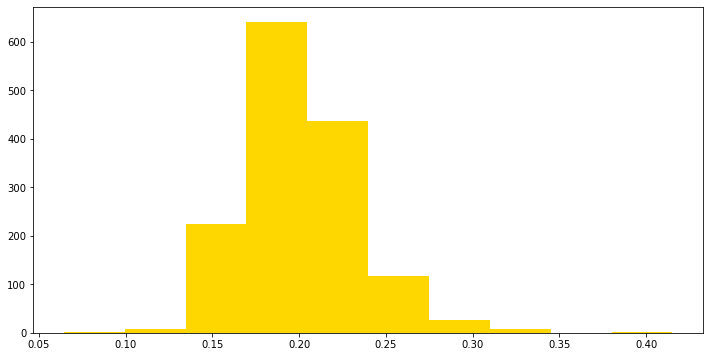

In [35]:
#plt.hist(list(overall_day_max_dict.values()),color='gold')
plt.rcParams["figure.figsize"] = (12,6)
plt.hist([pair[0] for pair in overall_day_max_dict.values()],color='gold')
plt.show()

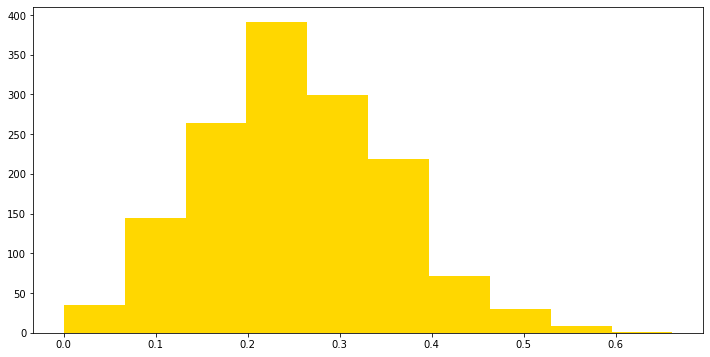

In [37]:
# this time view from an out of sector perspective
plt.hist([pair[1] for pair in overall_day_max_dict.values()],color='gold')
plt.show()

In [41]:
# find the day of our max for out of sector %
oos_list=[pair[1] for pair in overall_day_max_dict.values()]
list_max=max(oos_list)
max_index=list(oos_list).index(list_max)
print('max index:',max_index)
print('day:',list(overall_day_max_dict.keys())[max_index])
list(oos_list)[max_index]

max index: 486
day: 20180502


0.6619718309859155

In [ ]:
plt.hist(list(essential_day_max_dict.values()),color='purple')
plt.show()

In [ ]:
list_max=max(essential_day_max_dict.values())
max_index=list(essential_day_max_dict.values()).index(list_max)
list(essential_day_max_dict.keys())[max_index]

In [ ]:
# engines = red, medics = blue, rescue = black
x1 = list(overall_day_max_dict.values())
x2 = list(ambulance_day_max_dict.values())
x3 = list(engine_day_max_dict.values())
x4 = list(medic_day_max_dict.values())
x5 = list(rescue_day_max_dict.values())
x6 = list(ttt_day_max_dict.values())
bins = np.linspace(0,.9,20)
colors=['gold','red','blue','black']
plt.hist([x1,x3,x4,x5], bins, label=['overall','engine','medic','rescue'],color=colors)
plt.legend(loc='upper right'),
plt.show()

In [ ]:
# truck = green, amb = blue
colors=['gold','blue','green']
plt.hist([x1,x2,x6], bins, label=['overall','ambulance','ttt'],color=colors)
plt.legend(loc='upper right')
plt.show()

In [ ]:
bins=20
plt.hist(overall_day_max_dict.values(),bins,alpha=0.5, label='overall')
plt.hist(ambulance_day_max_dict.values(),bins,alpha=0.5, label='ambulance')
plt.hist(engine_day_max_dict.values(),bins,alpha=0.5, label='engine')
plt.hist(medic_day_max_dict.values(),bins,alpha=0.5, label='medic')
plt.hist(rescue_day_max_dict.values(),bins,alpha=0.5, label='rescue')
plt.hist(ttt_day_max_dict.values(),bins,alpha=0.5, label='ttt')
plt.legend(loc='upper right')
plt.show()

In [ ]:
total_days=len(overall_day_max_dict)
print('total days:',total_days)

In [ ]:
days_10_25=len([i for i in overall_day_max_dict.values() if i >= .1 and i < .25])
days_25_50=len([i for i in overall_day_max_dict.values() if i >= .25 and i < .5])
days_50=len([i for i in overall_day_max_dict.values() if i >= .5])

print('days 10% - 25%:',days_10_25,round(days_10_25/total_days,2))
print('days 25% - 50%:',days_25_50,round(days_25_50/total_days,2))
print('days 50%+:',days_50,round(days_50/total_days,2))

In [ ]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [16, 8] 
fig = plt.figure()
ax = plt.axes()
ax.xaxis.set_ticks(np.arange(1, 365, 30))
ax.plot(list(overall_day_max_dict.keys())[:365], list(overall_day_max_dict.values())[:365]);

In [ ]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [16, 8] 
fig = plt.figure()
ax = plt.axes()
ax.xaxis.set_ticks(np.arange(1, 365, 30))
ax.plot(list(overall_day_max_dict.keys())[365:365*2], list(overall_day_max_dict.values())[365:365*2]);

In [ ]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [16, 8] 
fig = plt.figure()
ax = plt.axes()
ax.xaxis.set_ticks(np.arange(1, 365, 30))
ax.plot(list(overall_day_max_dict.keys())[365*2:365*3], list(overall_day_max_dict.values())[365*2:365*3]);

In [ ]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [16, 8] 
fig = plt.figure()
ax = plt.axes()
ax.xaxis.set_ticks(np.arange(1, 365, 30))
ax.plot(list(overall_day_max_dict.keys())[365*3:365*4+1], list(overall_day_max_dict.values())[365*3:365*4+1]);

In [ ]:
day_of_week=[]
days_of_wk=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
week_len=len(days_of_wk)
counter=week_len
while counter < total_days:
    day_of_week+=days_of_wk
    counter+=week_len
    
diff=total_days-len(day_of_week)
day_of_week+=days_of_wk[:diff]
day_of_week[:20]

max_by_day_df = pd.DataFrame(
    {'day': overall_day_max_dict.keys(),
     'max_pct': overall_day_max_dict.values(),
     'day_of_week': day_of_week
    })
max_by_day_df

In [ ]:
# mark holidays
def mark_holidays(x):
    if x[4:]=='0101':
        return 'new years day'
    elif x[4:]=='1231':
        return 'new years eve'
    elif x[4:]=='1225':
        return 'xmas'
    elif x[4:]=='1224':
        return 'xmas eve'
    elif x[4:]=='1031':
        return 'halloween'
    elif x[4:]=='0704':
        return '4th of july'
    
    # specific thanksgiving dates
    elif x in ['20201126','20191128','20181122','20171123']:
        return 'thanksgiving'
    elif x in ['20201125','20191127','20181121','20171122']:
        return 'thanksgiving eve'
    elif x in ['20200907','20190902','20180903','20170904']:
        return 'labor day'
    elif x in ['20200525','20190527','20180528','20170529']:
        return 'memorial day'
    
    # nothing picked up return none
    return 'none'

max_by_day_df['holiday'] = max_by_day_df.apply(lambda x: mark_holidays(x['day']), axis=1)

In [ ]:
max_by_day_df[max_by_day_df['holiday']=='4th of july']

In [ ]:
new_df=max_by_day_df.groupby(['day_of_week']).mean()
res = new_df.apply(lambda x: x.sort_values(ascending=False))
print(res)
ax=res.unstack().plot.barh()
ax.invert_yaxis()

In [ ]:
new_df=max_by_day_df.groupby(['holiday']).mean()
res = new_df.apply(lambda x: x.sort_values(ascending=False))
print(res)
ax=res.unstack().plot.barh()
ax.invert_yaxis()

In [ ]:
max_df=pd.DataFrame.from_dict(max_dict.values())
max_df

In [ ]:
max_df=max_df[max_df['IncidentNumber'].isin(['E181221324','E181221450'])]
max_df[['UnitBattalion','UnitStation','CAD_UnitID','IncidentNumber']].groupby(['IncidentNumber','UnitBattalion']).agg(['count'])